/home/mgzszmzjz/.conda/envs/sf/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/mgzszmzjz/.conda/envs/sf/lib/python3.8/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


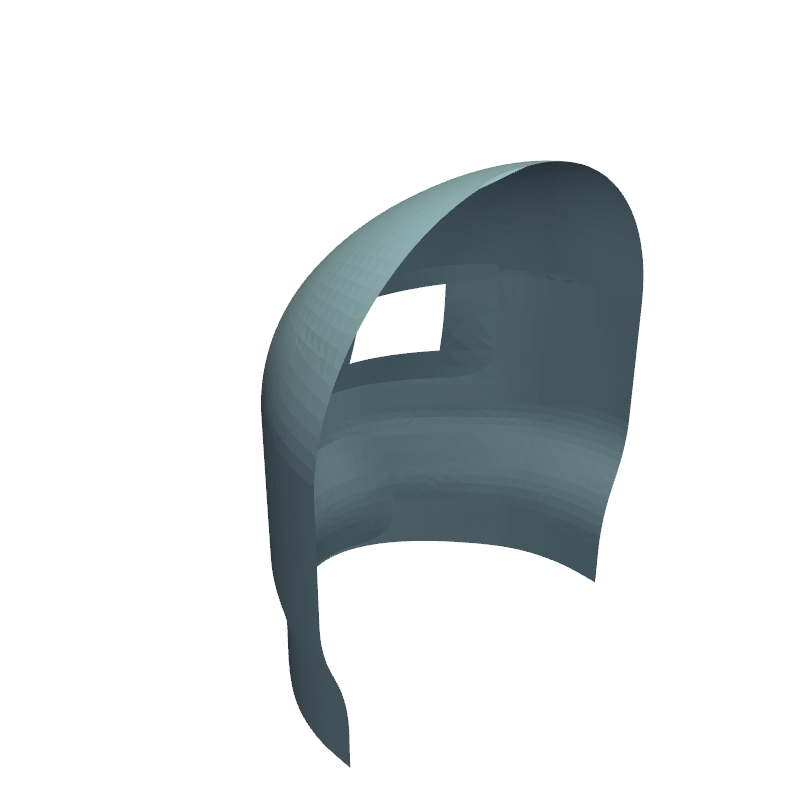

In [2]:
import numpy as np
from mayavi import mlab
import trimesh
import scipy.io as sio
from bfieldtools.mesh_conductor import MeshConductor
from bfieldtools.coil_optimize import optimize_streamfunctions

faceloop = trimesh.load_mesh(r"inner.STL")

rotation_matrix = np.array(
    [
    [ 1,  0,  0, 0],
    [ 0,  -1,  0, 0],
    [ 0,  0,  -1, 0],
    [ 0,  0,  0, 1]
    ]
)
faceloop.apply_transform(rotation_matrix)
coil = MeshConductor(mesh_obj=faceloop, fix_normals=True)
MeshConductor.plot_mesh(coil)

In [3]:
B0_map = sio.loadmat("B0_map_valid.mat")

b_k = B0_map['B0_data'].flatten() * 5 / 1e6
x_k = B0_map['X'].flatten() * 1000
y_k = B0_map['Y'].flatten() * 1000
z_k = B0_map['Z'].flatten() * 1000
target_points = np.stack([x_k, y_k, z_k], axis=1)

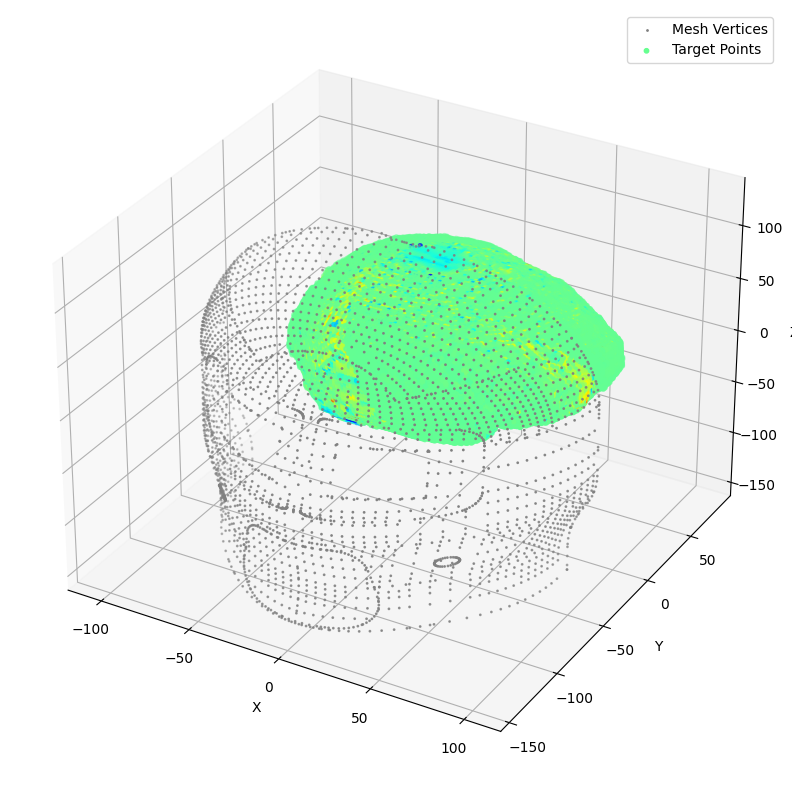

In [4]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

mesh_verts = faceloop.vertices
ax.scatter(mesh_verts[:, 0], mesh_verts[:, 1], mesh_verts[:, 2], s=1, c='gray', label='Mesh Vertices')

ax.scatter(target_points[:, 0], target_points[:, 1], target_points[:, 2], s=10, c=b_k, cmap = 'jet', label='Target Points')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.tight_layout()
plt.show()

In [5]:
target_field = b_k.reshape(-1, 1) 
target_abs_error = np.ones_like(target_field) * 1e-6

sample_rate = 50
target_points = target_points[::sample_rate]
target_field = target_field[::sample_rate]
target_abs_error = target_abs_error[::sample_rate]

target_spec = {
    "coupling": coil.B_coupling(target_points)[:, 2, :], 
    "abs_error": target_abs_error,
    "target": target_field,
}

Computing magnetic field coupling matrix, 2821 vertices by 8067 target points... took 7.09 seconds.


In [6]:
import pickle
coil.s, prob = optimize_streamfunctions(
    coil,
    [target_spec],
    objective="minimum_inductive_energy",
    solver="SCS"
)


Computing the inductance matrix...
Computing self-inductance matrix using rough quadrature (degree=2).              For higher accuracy, set quad_degree to 4 or more.
Estimating 28392 MiB required for 2821 by 2821 vertices...
Computing inductance matrix in 20 chunks (230809 MiB memory free),              when approx_far=True using more chunks is faster...
Computing triangle-coupling matrix
Inductance matrix computation took 14.10 seconds.
Passing problem to solver...
                                     CVXPY                                     
                                     v1.5.2                                    
(CVXPY) 4月 28 08:33:47 下午: Your problem has 2570 variables, 16134 constraints, and 0 parameters.
(CVXPY) 4月 28 08:33:47 下午: It is compliant with the following grammars: DCP, DQCP
(CVXPY) 4月 28 08:33:47 下午: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) 4月 28 08:33:47 下午: CVXPY will first compile your p

/home/mgzszmzjz/.conda/envs/sf/lib/python3.8/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [7]:
import pyvista as pv
pv.set_jupyter_backend('static')

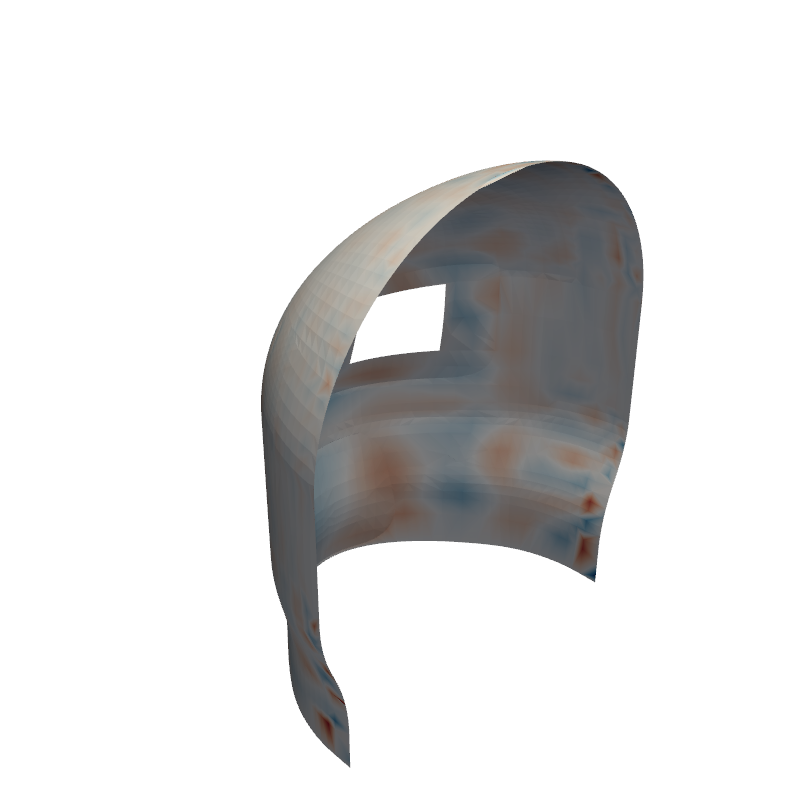

<class 'pyvista.plotting.plotter.Plotter'>


In [ ]:
s = coil.s.plot(ncolors=64)


<class 'pyvista.plotting.plotter.Plotter'>


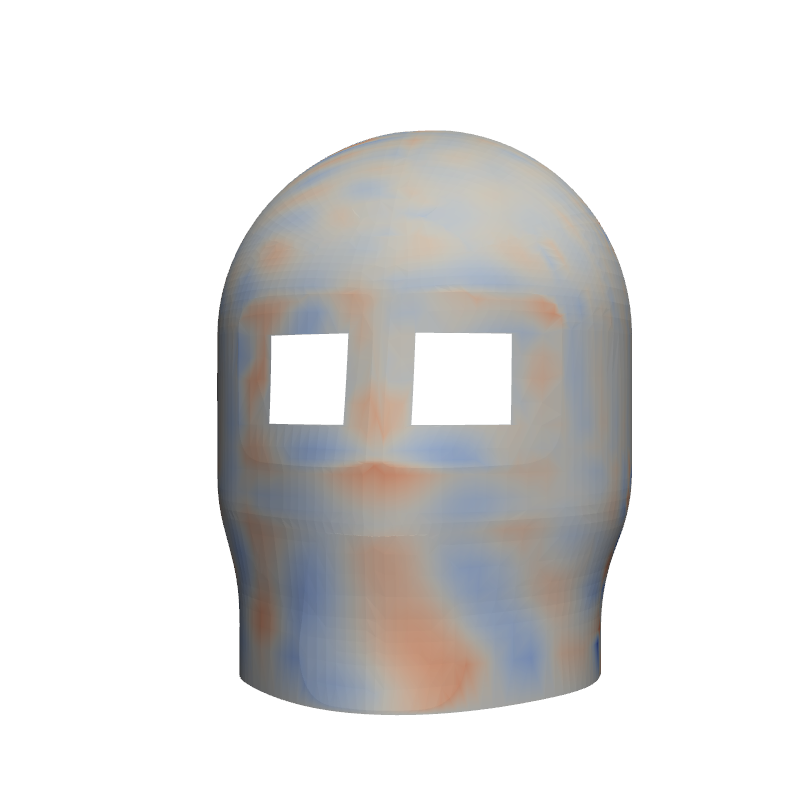

In [20]:
print(type(s))
s.add_mesh(s.mesh, cmap="coolwarm", show_scalar_bar=False)  
s.view_vector([1, -5, 0])   
s.show(screenshot="new_view.png")  


Processing contour, value: -535641293.62365425
Processing contour, value: -455974823.9163397
Processing contour, value: -376308354.2090252
Processing contour, value: -296641884.50171065
Processing contour, value: -216975414.79439616
Processing contour, value: -137308945.0870816
Processing contour, value: -57642475.37976712
Processing contour, value: 22023994.32754743
Processing contour, value: 101690464.03486192
Processing contour, value: 181356933.7421764
Processing contour, value: 261023403.44949102
Processing contour, value: 340689873.1568055
Processing contour, value: 420356342.86412
Processing contour, value: 500022812.5714346
Processing contour, value: 579689282.2787491


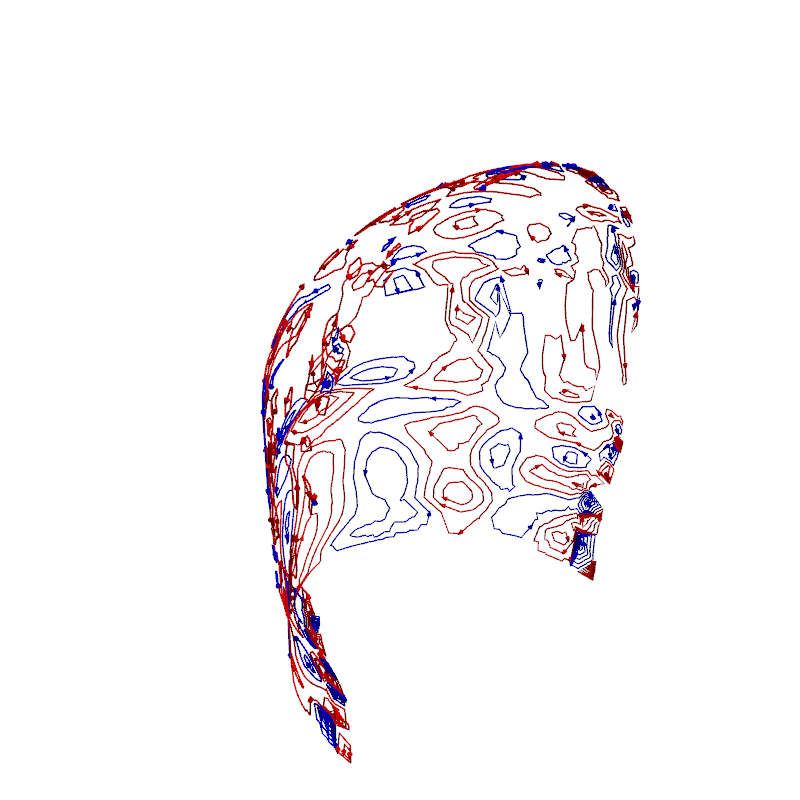

<class 'pyvista.plotting.plotter.Plotter'>


In [23]:
loops = coil.s.discretize(N_contours=15)
l = loops.plot_loops(tube_radius = 0.4)
print(type(l))

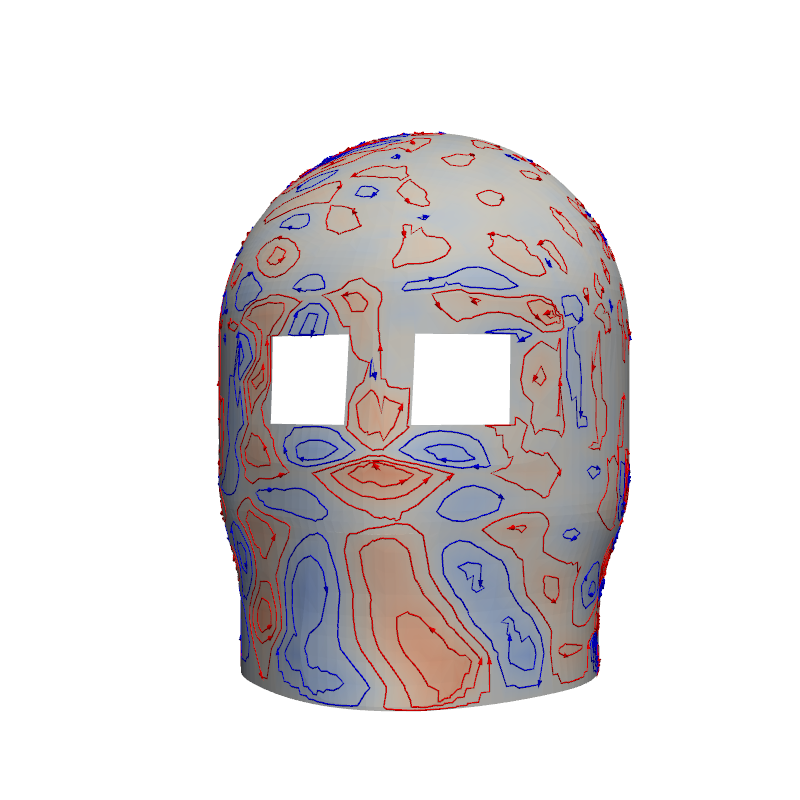

In [25]:
l.add_mesh(s.mesh,cmap='coolwarm', show_scalar_bar=False)  # 设置为 jet 色图
l.view_vector([1, -5, 0])   # 或者改成你想要的方向，比如 [0, 0, 1] 是正上方
l.show()

In [12]:
discrete_loops = coil.s.discretize(N_contours=5)

loop_coords = [e.discrete(discrete_loops.vertices) for e in discrete_loops.entities] 

with open("all_loops_v3.txt", "w") as f:
    for i, loop in enumerate(loop_coords):
        f.write(f"# Loop {i}\n")
        np.savetxt(f, loop, fmt="%.6f", delimiter="\t")
        f.write("\n")


Processing contour, value: -455974823.9163397
Processing contour, value: -216975414.79439616
Processing contour, value: 22023994.32754743
Processing contour, value: 261023403.44949102
Processing contour, value: 500022812.5714346


In [13]:
import numpy as np
from scipy.io import savemat

# 假设 loop 是一组数组，每个元素是 (N点, 3) 的 array
# 例子：loop = [array([[x1, y1, z1], [x2, y2, z2], ...]), array(...), ...]

X_list, Y_list, Z_list = [], [], []

for l in loop_coords:
    X_list.append(l[:, 0])  # 第一列是 X
    Y_list.append(l[:, 1])  # 第二列是 Y
    Z_list.append(l[:, 2])  # 第三列是 Z

# 转成 object array
X = np.array(X_list, dtype=object)
Y = np.array(Y_list, dtype=object)
Z = np.array(Z_list, dtype=object)

# 保存为 .mat 文件
savemat("coiltrace_sf_v3.mat", {"X": X, "Y": Y, "Z": Z})
